* Done By: Mohammed Abu Amira.
* Linkedin: https://www.linkedin.com/in/mohamedabuamira

# Introduction 

**Melanoma**, also known as **malignant melanoma**, is a type of *skin cance*r that develops from the pigment-producing cells known as melanocytes.

**seborrheic keratosis** is a non-cancerous (benign) skin tumour that originates from cells in the outer layer of the skin.

**Nevus** (plural nevi) is a nonspecific medical term for a visible, circumscribed, chronic lesion of the skin or mucosa.

![picture](https://d17h27t6h515a5.cloudfront.net/topher/2017/November/5a18789d_skin-disease-classes/skin-disease-classes.png)


Create model that can visually diagnose melanoma, the deadliest form of skin cancer. In particular, the algorithm will distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).

In [248]:
from urllib.request import urlretrieve
from os.path import isfile, isdir, join
from os import listdir
import os
from tqdm import tqdm
import zipfile

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf


import keras
from tensorflow.keras import Sequential
from keras import layers
from keras.layers import Dropout , Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
  
 

In [249]:
print("TensorFlow Version", tf.__version__)
print("Keras Version", keras.__version__)

TensorFlow Version 2.3.0
Keras Version 2.4.3


# Download Datasets

Make new folder to download the datasets

In [250]:
colab_base_path="/content"
#change to "/content"
print("Change directory to: ", os.chdir(colab_base_path))

Change directory to:  None


In [251]:
# Function to Get the current  
# working directory 
def current_path(rest_to_base=False):
  if rest_to_base:
    os.chdir(colab_base_path)

  current_path= os.getcwd()
  return os.getcwd()

print("Current working directory:", current_path())  

Current working directory: /content


In [252]:
# create "Data" Folder in the current path
  
# Directory 
directory = "Data"
  
# Parent Directory path 
parent_dir = current_path()
  
# Path 
data_path = os.path.join(parent_dir, directory) 
  
# Create the directory 
# 'Data' 
try: 
    os.makedirs(data_path, exist_ok = True) 
    print("Directory '%s' created successfully" % directory) 
except OSError as error: 
    print("Directory '%s' can not be created" % directory) 

Directory 'Data' created successfully


In [253]:
# Changing the path to Data 
os.chdir(data_path)
  
# Printing after 
print("The current path:", current_path())

The current path: /content/Data


In [254]:
# training data (5.3 GB)

# validation data (824.5 MB)

# test data (5.1 GB)

url_train_data="https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
url_valid_data="https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
url_test_data="https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"

zip_train="train.zip"
zip_valid="valid.zip"
zip_test="test.zip"

In [255]:
def download_extract_dataset(data_path, zip_file, url_data):
    print("\nThe path to download will be:", data_path)

    zip_file = zip_file              # The file to download
    folder_name=zip_file[:-4]            # The file will extracted in this folder, its name as file name, without extension

    dataset_folder_path = os.path.join(data_path, folder_name)         # The path of "folder name"




    class DLProgress(tqdm):
        last_block = 0

        def hook(self, block_num=1, block_size=1, total_size=None):
            self.total = total_size
            self.update((block_num - self.last_block) * block_size)
            self.last_block = block_num

    if not isfile(zip_file) and not isdir(dataset_folder_path):   
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc=folder_name) as pbar:
            urlretrieve(url_data, zip_file, pbar.hook)

        print("{} file is downloaded in {}".format(zip_file, data_path))

    else:
        print("The file {} is already downloaded or extracted".format(zip_file))

    if not isdir(dataset_folder_path):
      zip_ref = zipfile.ZipFile(zip_file, "r")
      zip_ref.extractall()
      zip_ref.close()
      print("{} file is extracted in {}".format(zip_file, data_path))

    if isfile(zip_file):

      # Remove thezip file   
      # file path  
      try:  
          os.remove(zip_file)  
          print("% s removed successfully" % zip_file)  
      except OSError as error:  
          print(error)  
          print("File path can not be removed") 

    if isdir(dataset_folder_path): # check
       print("The folders in %s :" %dataset_folder_path)
       print(os.listdir(dataset_folder_path))


In [256]:
download_extract_dataset(data_path=data_path, zip_file=zip_train, url_data=url_train_data)


The path to download will be: /content/Data
The file train.zip is already downloaded or extracted
The folders in /content/Data/train :
['seborrheic_keratosis', 'nevus', 'melanoma']


In [257]:
download_extract_dataset(data_path=data_path, zip_file=zip_valid, url_data=url_valid_data)


The path to download will be: /content/Data
The file valid.zip is already downloaded or extracted
The folders in /content/Data/valid :
['seborrheic_keratosis', 'nevus', 'melanoma']


In [258]:
download_extract_dataset(data_path=data_path, zip_file=zip_test, url_data=url_test_data)


The path to download will be: /content/Data
The file test.zip is already downloaded or extracted
The folders in /content/Data/test :
['seborrheic_keratosis', 'nevus', 'melanoma']


In [259]:
# change the path to the base
print("The current path: ", current_path(rest_to_base=False))

print("The path after change:", current_path(rest_to_base=True))

The current path:  /content/Data
The path after change: /content


# Creating Datasets

## Check and setup

**Note: The folder names in Train, valid, and test folders are the labels names.
`['melanoma', 'nevus', 'seborrheic_keratosis']`**

In [260]:
TRAIN_DIR="/content/Data/train"
VALID_DIR="/content/Data/valid"
TEST_DIR="/content/Data/test"

DATA_DIRs=[TRAIN_DIR, VALID_DIR, TEST_DIR]

label_names=['melanoma', 'nevus', 'seborrheic_keratosis']

In [261]:
# Count the number of images in every folder 
total=0
ALL_DIRs=[]
sum_img=0
for dir in DATA_DIRs:

  print("\n{}/".format(dir))

  for label in label_names:
    path= os.path.join(dir, label + "/")
    ALL_DIRs.append(path)                 # Det all paths 

    file_lists = os.listdir(path)
    num_files=len(file_lists)
    sum_img += num_files
    print("\n---------------------{}/<{} Images>".format(label, num_files))
  
  print("\nTotal Images In {}:{}".format(dir[14:], sum_img))
  print("-------------------------------------------------------")
  total += sum_img
  sum_img=0

print("Total Images in All:", total)




/content/Data/train/

---------------------melanoma/<374 Images>

---------------------nevus/<1372 Images>

---------------------seborrheic_keratosis/<254 Images>

Total Images In train:2000
-------------------------------------------------------

/content/Data/valid/

---------------------melanoma/<30 Images>

---------------------nevus/<78 Images>

---------------------seborrheic_keratosis/<42 Images>

Total Images In valid:150
-------------------------------------------------------

/content/Data/test/

---------------------melanoma/<117 Images>

---------------------nevus/<393 Images>

---------------------seborrheic_keratosis/<90 Images>

Total Images In test:600
-------------------------------------------------------
Total Images in All: 2750


In [262]:
print("All dirs:", ALL_DIRs)

All dirs: ['/content/Data/train/melanoma/', '/content/Data/train/nevus/', '/content/Data/train/seborrheic_keratosis/', '/content/Data/valid/melanoma/', '/content/Data/valid/nevus/', '/content/Data/valid/seborrheic_keratosis/', '/content/Data/test/melanoma/', '/content/Data/test/nevus/', '/content/Data/test/seborrheic_keratosis/']


In [263]:
# Get all files in train data
ALL_FILES=dict()
for dir in ALL_DIRs:
  ALL_FILES[dir]=[dir+f for f in listdir(dir) if isfile(join(dir, f))]

In [264]:
print("All files in", ALL_FILES.keys())

All files in dict_keys(['/content/Data/train/melanoma/', '/content/Data/train/nevus/', '/content/Data/train/seborrheic_keratosis/', '/content/Data/valid/melanoma/', '/content/Data/valid/nevus/', '/content/Data/valid/seborrheic_keratosis/', '/content/Data/test/melanoma/', '/content/Data/test/nevus/', '/content/Data/test/seborrheic_keratosis/'])


In [265]:
# check example
img_melanoma=ALL_FILES['/content/Data/train/melanoma/'][0]
print("Image path:", img_melanoma)
img=plt.imread(img_melanoma)
print("The shape of image:", img.shape)
print("Max: {} , Min: {}".format(img.max(), img.min()))


Image path: /content/Data/train/melanoma/ISIC_0001128.jpg
The shape of image: (2304, 3072, 3)
Max: 255 , Min: 0


### Disply some images

In [266]:
# Define a function to display images

def display_six_images(image_dir, title=None):
  plt.figure(figsize=(12,12))
  for i in range(6):
    plt.subplot(3,3 ,1+i)
    img=plt.imread(image_dir[i])
    plt.imshow(img)
    plt.title(title)
    plt.tight_layout()
  plt.show


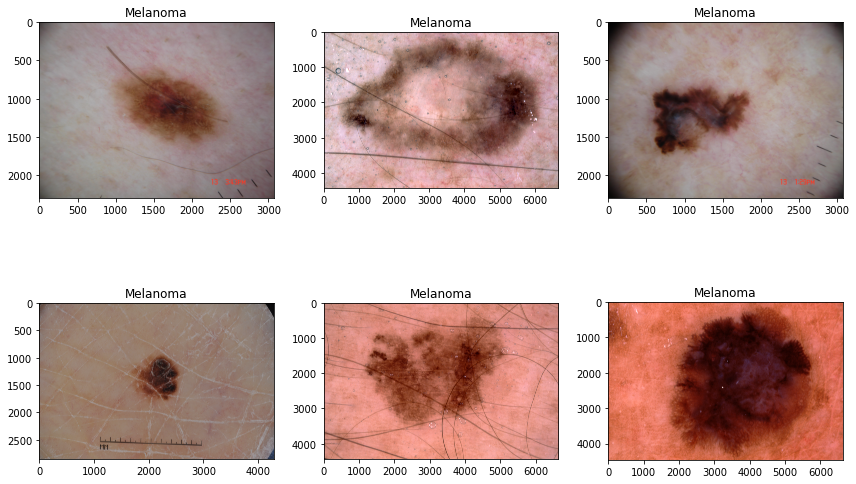

In [267]:
display_six_images(ALL_FILES['/content/Data/train/melanoma/'], title="Melanoma")

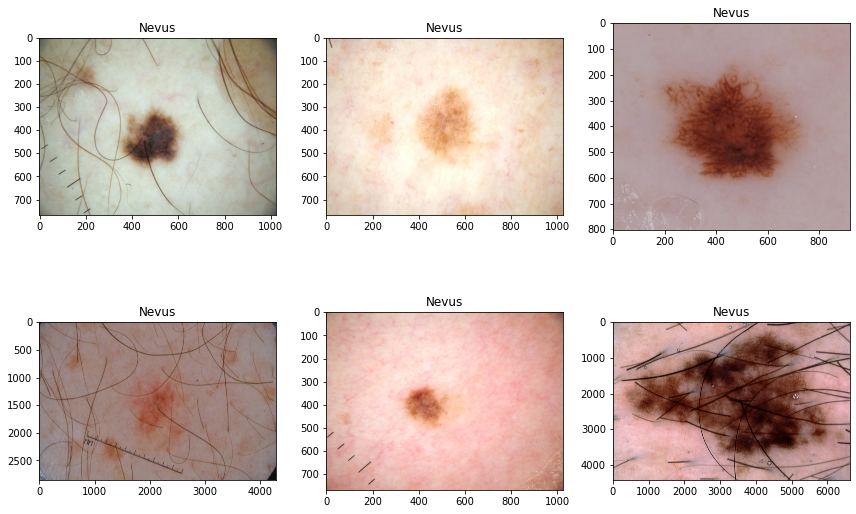

In [268]:
display_six_images(ALL_FILES['/content/Data/train/nevus/'], title="Nevus")

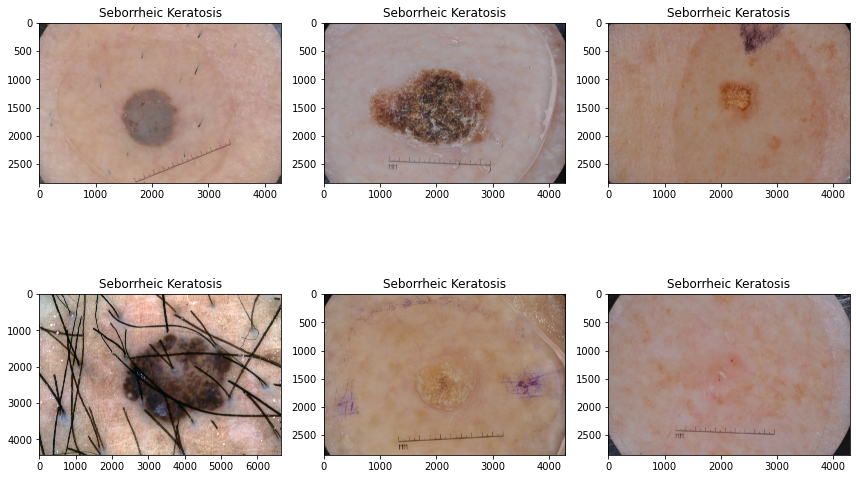

In [269]:
display_six_images(ALL_FILES['/content/Data/train/seborrheic_keratosis/'], title="Seborrheic Keratosis")

### Define basic parameters and functions 

In [270]:
# Basic Parameters 

BATCH_SIZE = 32
IMG_HEIGHT = 200
IMG_WIDTH = 200



AUTOTUNE = tf.data.experimental.AUTOTUNE

In [271]:
# When create datasets from directory I need to get all files in folder based on a pattern

patterns=[]
for dir in DATA_DIRs:
  format_pattern= dir + '/*/*'
  patterns.append(format_pattern)

patterns

['/content/Data/train/*/*',
 '/content/Data/valid/*/*',
 '/content/Data/test/*/*']

The functions from [TensorFlow](https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control)

In [272]:
# Write a short function that converts a file path to an (img, label) pair:

def get_label(file_path):
  
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)

  # The second to last is the class-directory
  one_hot = parts[-2] == label_names

  # Integer encode the label
  return tf.argmax(one_hot)

In [273]:
'''
Note That the lables of class names will be 
['melanoma', 'nevus', 'seborrheic_keratosis']         # class names
     0,         1,             2                      # Lables


'''

"\nNote That the lables of class names will be \n['melanoma', 'nevus', 'seborrheic_keratosis']         # class names\n     0,         1,             2                      # Lables\n\n\n"

In [274]:
def decode_resize_rescal_img(img):
  """
  Takes an image file path and turns it into a Tensor.
  """
  
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue) <3D uint8 tensor>
  img = tf.image.decode_jpeg(img, channels=3)

  # Convert the colour channel values from 0-225 values to 0-1 values
  img= tf.image.convert_image_dtype(img, tf.float32)

  # Resize the image to our desired size (224, 244)
  img= tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
  return img

In [275]:
# Data augmentation, do that JUST for TRAIN data

def data_augment(img, label):
  img= tf.image.random_flip_left_right(img)
  img= tf.image.random_flip_up_down(img)
  img= tf.image.random_brightness(img, max_delta=0.5) # Random brightness
  img= tf.image.adjust_saturation(img, 3)
  
  return img, label

In [276]:
def process_path(file_path):

  label = get_label(file_path)
  # load the raw data from the file as a string
  
  img = tf.io.read_file(file_path)
  img = decode_resize_rescal_img(img)

  return img, label

In [277]:
# Configure dataset for performance
def configure_for_performance(ds, buffer_size=None, shuffle=False):
  ds = ds.cache()

  if shuffle:
     ds = ds.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=False)   # shuffle JUST to TRAIN data
     ds = ds.batch(BATCH_SIZE)
     ds = ds.prefetch(buffer_size=AUTOTUNE)
     return ds

  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

## Create Train Dataset

In [278]:
train_ds=None

# get all files in train data
train_ds = tf.data.Dataset.list_files(patterns[0], shuffle=False)
          

In [279]:
# check
for file in train_ds.take(5):
  print(file.numpy())

b'/content/Data/train/melanoma/ISIC_0000002.jpg'
b'/content/Data/train/melanoma/ISIC_0000004.jpg'
b'/content/Data/train/melanoma/ISIC_0000013.jpg'
b'/content/Data/train/melanoma/ISIC_0000022.jpg'
b'/content/Data/train/melanoma/ISIC_0000026.jpg'


In [280]:
# the lenght of train dataset
print("The lenght of train dataset:", tf.data.experimental.cardinality(train_ds).numpy())

The lenght of train dataset: 2000


In [281]:
# Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)                # process all image from paths, to get img, label
train_ds = train_ds.map(data_augment, num_parallel_calls=AUTOTUNE)               # agument all image, take img, label, and then return them 

In [282]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  print("Max: {} , Min: {}".format(image.numpy().max(), image.numpy().min()))

Image shape:  (200, 200, 3)
Label:  0
Max: 1.2273705005645752 , Min: 0.0


In [283]:
# Configure dataset for performance
train_ds= configure_for_performance(train_ds, shuffle=True, buffer_size=2000)   # 2000 for num images in train data

## Create Valid Dataset

In [284]:
valid_ds=None

# get all files in valid data
valid_ds = tf.data.Dataset.list_files(patterns[1], shuffle=False)

# check
for file in valid_ds.take(5):
  print(file.numpy())

b'/content/Data/valid/melanoma/ISIC_0012099.jpg'
b'/content/Data/valid/melanoma/ISIC_0012151.jpg'
b'/content/Data/valid/melanoma/ISIC_0012288.jpg'
b'/content/Data/valid/melanoma/ISIC_0012434.jpg'
b'/content/Data/valid/melanoma/ISIC_0013232.jpg'


In [285]:
# the lenght of valid dataset
print("The lenght of valid dataset:", tf.data.experimental.cardinality(valid_ds).numpy())

The lenght of valid dataset: 150


In [286]:
# Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
valid_ds = valid_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [287]:
for image, label in valid_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (200, 200, 3)
Label:  0


In [288]:
# Configure dataset for performance
valid_ds= configure_for_performance(valid_ds, shuffle=False)

## Creat Test Dataset

In [289]:
test_ds=None

# get all files in train data
test_ds = tf.data.Dataset.list_files(patterns[2], shuffle=False)

# check
for file in test_ds.take(5):
  print(file.numpy())

b'/content/Data/test/melanoma/ISIC_0012258.jpg'
b'/content/Data/test/melanoma/ISIC_0012356.jpg'
b'/content/Data/test/melanoma/ISIC_0012369.jpg'
b'/content/Data/test/melanoma/ISIC_0012395.jpg'
b'/content/Data/test/melanoma/ISIC_0012425.jpg'


In [290]:
# the lenght of test dataset
print("The lenght of test dataset:", tf.data.experimental.cardinality(test_ds).numpy())

The lenght of test dataset: 600


In [291]:
# Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [292]:
for image, label in test_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (200, 200, 3)
Label:  0


In [293]:
# Configure dataset for performance
test_ds= configure_for_performance(test_ds, shuffle=False)



---



---



In [294]:
# Output of Train datasets
image_batch, label_batch = next(iter(train_ds))
print('Image Batch Shape = {}'.format(image_batch.shape))
print('Labels Batch Shape = {}'.format(label_batch.shape))



Image Batch Shape = (32, 200, 200, 3)
Labels Batch Shape = (32,)


In [295]:
print("Number of baches in train data:", len(train_ds))
print("Number of baches in Val data:", len(valid_ds))
print("Number of baches in test data:", len(test_ds))

Number of baches in train data: 63
Number of baches in Val data: 5
Number of baches in test data: 19


## Visualize the data from dataset

In [298]:
def disply_batch_data(image_batch, label_batch):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title("{} ({})".format(label_names[label],label))
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


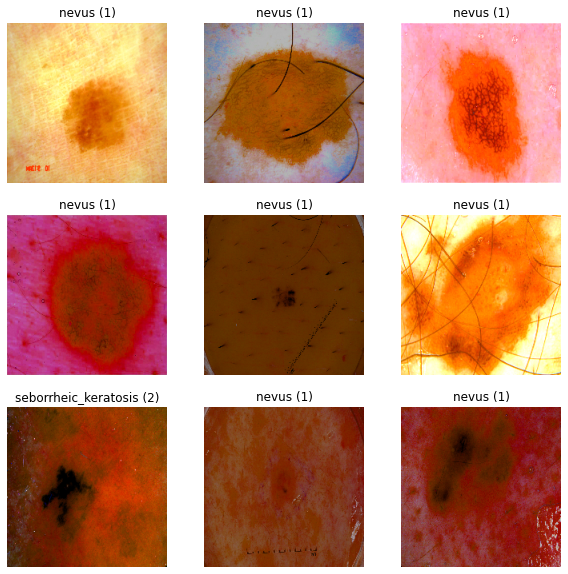

In [299]:
image_batch_, label_batch_ = next(iter(train_ds))
disply_batch_data(image_batch=image_batch_, label_batch=label_batch_)



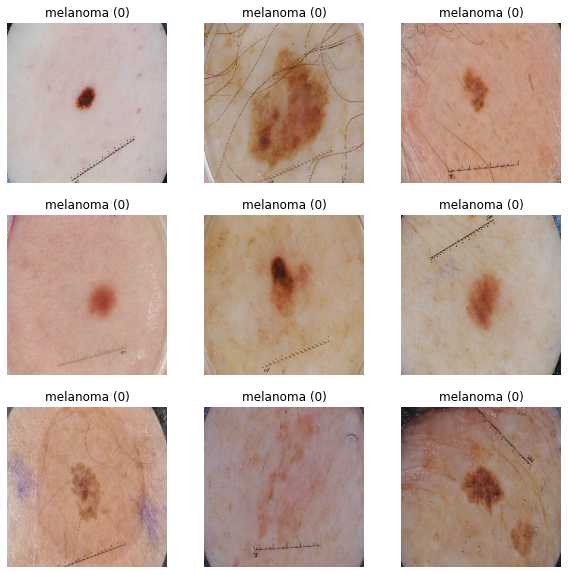

In [300]:
image_batch_, label_batch_ = next(iter(valid_ds))
disply_batch_data(image_batch=image_batch_, label_batch=label_batch_)

# Create CNN model 

In [301]:
def CNN_model():

    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))) # shape 200*200*3
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Conv Block 2
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Conv Block 3
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Conv Block 4
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(Conv2D(128, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Conv Block 5
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Out
    model.add(Dense(3, activation = 'softmax'))

    return model

In [302]:
model=CNN_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 99, 99, 16)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 99, 99, 16)        64        
_________________________________________________________________
dropout_23 (Dropout)         (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 97, 97, 32)        4640      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 95, 95, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 47, 47, 32)       

In [303]:
# Set a learning rate annealer
learning_rate_redcuing=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                         patience=3,
                                         verbose=1,
                                         factor=0.3,
                                         min_lr=0.00001)

In [304]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()

In [305]:
#set optimizer
opt= tf.keras.optimizers.RMSprop(learning_rate=0.0001)

In [306]:
#compile the model
model.compile(loss = loss_fn, optimizer = opt, metrics = ['accuracy'])

In [307]:
model.fit(train_ds,
              steps_per_epoch = len(train_ds),
              epochs =20,
              validation_data = valid_ds,
              validation_steps=len(valid_ds),
              callbacks=learning_rate_redcuing)
                              
                              


Epoch 1/20
63/63 [==============================] - 35s 548ms/step - loss: 1.4262 - accuracy: 0.3845 - val_loss: 1.1542 - val_accuracy: 0.2000
Epoch 2/20
63/63 [==============================] - 5s 86ms/step - loss: 1.1965 - accuracy: 0.4375 - val_loss: 1.1004 - val_accuracy: 0.5200
Epoch 3/20
63/63 [==============================] - 5s 85ms/step - loss: 1.1119 - accuracy: 0.4770 - val_loss: 1.0581 - val_accuracy: 0.5200
Epoch 4/20
63/63 [==============================] - 5s 85ms/step - loss: 1.0324 - accuracy: 0.5280 - val_loss: 1.0573 - val_accuracy: 0.5200
Epoch 5/20
62/63 [============================>.] - ETA: 0s - loss: 0.9753 - accuracy: 0.5484
Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
63/63 [==============================] - 5s 85ms/step - loss: 0.9751 - accuracy: 0.5490 - val_loss: 1.0819 - val_accuracy: 0.5200
Epoch 6/20
63/63 [==============================] - 5s 85ms/step - loss: 0.8627 - accuracy: 0.6025 - val_loss: 1.0262 - val_accur

# Evaluate the model

## Training and validation curves

In [308]:
import matplotlib.pyplot as plt 
from pylab import rcParams

# Plot Result Graph for Accuracy, Loss and Validation
# Source: https://github.com/vb100/Pneumonia-X-Rays-of-Human-Lungs-AI-project/blob/master/vb100_utils.py
def plot_model_result(model):
	'''
		-- model : Keras model.
	'''

	rcParams['figure.figsize'] = 14, 4 # Set plot size

	# Plot #1

	y1 = model.history.history['val_accuracy']
	y2 = model.history.history['accuracy']

	_ = plt.title('Model Results', family='DejaVu Sans', fontsize=15)

	_ = plt.plot(y1, 
		color='blue', linewidth=1.5, marker='D', markersize=5,
		label='Validation acc.')
	_ = plt.plot(y2, 
		color='#9999FF', linewidth=1.5, marker='D', markersize=5,
		label='Training acc.')

	_ = plt.xlabel('Epochs', family='DejaVu Sans', fontsize=10)
	_ = plt.ylabel('Score', family='DejaVu Sans', fontsize=10)

	_ = plt.yticks(np.arange(0., 1.25, 0.1),
				   family='DejaVu Sans', fontsize=10)

	if len(model.history.history['accuracy']) < 51:
		_ = plt.xticks(np.arange(0, len(model.history.history['accuracy']), 1),
					   family='DejaVu Sans', fontsize=10)

	_ = plt.ylim((0., 1.))

	_ = plt.fill_between(np.arange(0, len(model.history.history['accuracy']), 1),
						 model.history.history['accuracy'], 0,
						 color = '#cccccc', alpha=0.5)

	_ = plt.grid(which='major', color='#cccccc', linewidth=0.5)
	_ = plt.legend(loc='best', shadow=True)
	_ = plt.margins(0.02)

	_ = plt.show()

	# Plot #2
	_ = plt.clf()

	_ = plt.plot(model.history.history['val_loss'], 
		color='red', linewidth=1.5, marker='D', markersize=5,
		label='Validation loss')
	_ = plt.plot(model.history.history['loss'], 
		color='#FF7F7F', linewidth=1.5, marker='D', markersize=5,
		label='Loss')

	_ = plt.xlabel('Epochs', family='DejaVu Sans', fontsize=10)
	_ = plt.ylabel('Loss score', family='DejaVu Sans', fontsize=10)

	if len(model.history.history['accuracy']) < 51:
		_ = plt.xticks(np.arange(0, len(model.history.history['accuracy']), 1),
					   family='DejaVu Sans', fontsize=10)
	_ = plt.yticks(family='DejaVu Sans', fontsize=10)

	_ = plt.grid(which='major', color='#cccccc', linewidth=0.5)
	_ = plt.legend(loc='best', shadow=True)
	_ = plt.margins(0.02)

	_ = plt.show()

	return None


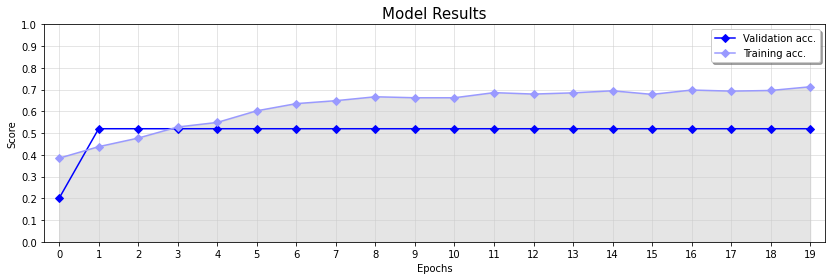

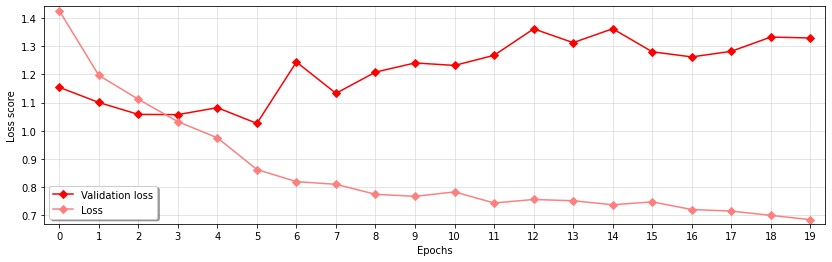

In [309]:
plot_model_result(model)

In [310]:
# Evaluate the model on test data
predictions = model.evaluate(test_ds)

19/19 [==============================] - 177s 9s/step - loss: 1.0204 - accuracy: 0.6567


In [311]:
print(f"The losses of test data: {predictions[0]}")
print(f"The accuracy of test data: {predictions[1]}")

The losses of test data: 1.020440697669983
The accuracy of test data: 0.6566666960716248


## Predictions and confusion matrix

In [313]:
pred= model.predict(test_ds)

predicted_label_indices=np.argmax(pred, axis=1)     # Get labels for all predictions

predictions_label_names=[label_names[k] for k in predicted_label_indices]   # Get label names that predicted 


In [314]:
print("The label names are", label_names)

print("The first five prediction:\n", pred[:][:5])
print("The first five prediction labels: ", predicted_label_indices[:5])
print("The first five prediction label names: ",predictions_label_names[:5])

The label names are ['melanoma', 'nevus', 'seborrheic_keratosis']
The first five prediction:
 [[0.04149021 0.888565   0.06994489]
 [0.08153345 0.837052   0.08141454]
 [0.05447546 0.8772462  0.06827836]
 [0.0652139  0.8662532  0.06853297]
 [0.04500329 0.89792514 0.05707163]]
The first five prediction labels:  [1 1 1 1 1]
The first five prediction label names:  ['nevus', 'nevus', 'nevus', 'nevus', 'nevus']


In [318]:
# Get the true labels of test data
# unbatch a batched dataset
test_dataset_labels=[]
test_dataset_name_labels=[]
#images = []
labels = []
# Loop through unbatched data
for image, label in test_ds.unbatch().as_numpy_iterator():
  #images.append(image)
  test_dataset_name_labels.append(label_names[label])
  test_dataset_labels.append(label)


In [319]:
# check the lenght
print("The length of test dataset labels: ", len(test_dataset_labels))    # should be 600 labels

The length of test dataset labels:  600


In [320]:
print("The five items of test dataset labels: ", test_dataset_labels[:5])  

The five items of test dataset labels:  [0, 0, 0, 0, 0]


In [321]:
print("The five items of test dataset label names: ", test_dataset_name_labels[:5])  

The five items of test dataset label names:  ['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']


In [322]:
# no. of True classifed labels in that batch
print("The Number of Successfully classified Images:", sum(test_dataset_labels==predicted_label_indices))

The Number of Successfully classified Images: 394


[Text(69.0, 0.5, 'True label'),
 Text(0.5, 117.59999999999997, 'Predicted label'),
 Text(0.5, 1.0, 'Confusion Matrix')]

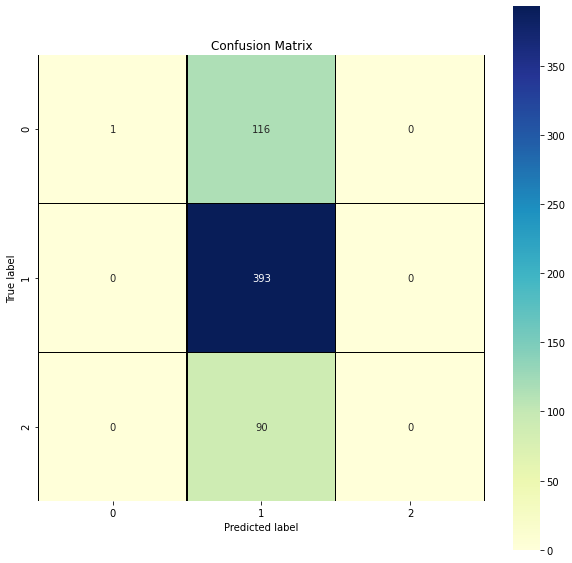

In [323]:
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
import seaborn as sns
# compute the confusion matrix
confusion_mtx=confusion_matrix(test_dataset_name_labels, predictions_label_names)

# plot the confusion matrix
plt.figure(figsize=(10, 10)) #The size of plot chart
conf_plot=sns.heatmap(confusion_mtx, annot=True, fmt='d', linewidths=.1, linecolor='black', cmap="YlGnBu", square=True)

#set title and labels
conf_plot.set(xlabel="Predicted label", ylabel = 'True label', title='Confusion Matrix')

In [325]:
print('{} \n{} \n{}'.format(confusion_mtx, 
                           classification_report(test_dataset_name_labels, predictions_label_names) , 
                           accuracy_score(test_dataset_name_labels, predictions_label_names)))

[[  1 116   0]
 [  0 393   0]
 [  0  90   0]] 
                      precision    recall  f1-score   support

            melanoma       1.00      0.01      0.02       117
               nevus       0.66      1.00      0.79       393
seborrheic_keratosis       0.00      0.00      0.00        90

            accuracy                           0.66       600
           macro avg       0.55      0.34      0.27       600
        weighted avg       0.62      0.66      0.52       600
 
0.6566666666666666


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Check the predictions




In [327]:
for image_batch, label_batch in test_ds:
    print('Data Batch Shape = {}'.format(image_batch.shape))
    print('Labels Batch Shape = {}'.format(label_batch.shape))
    break

Data Batch Shape = (32, 200, 200, 3)
Labels Batch Shape = (32,)


In [330]:
# Run the image batch through the model and convert the indices to class names.

predicted_batch = model.predict(image_batch)
predicted_labels = np.argmax(predicted_batch, axis=-1)
predicted_label_names = [label_names[k] for k in predicted_labels]

In [333]:
print("The predictions of the batch:\n", predicted_batch)

The predictions of the batch:
 [[0.04149021 0.888565   0.06994489]
 [0.08153345 0.837052   0.08141454]
 [0.05447546 0.8772462  0.06827836]
 [0.0652139  0.8662532  0.06853297]
 [0.04500329 0.89792514 0.05707163]
 [0.04519717 0.90111846 0.05368444]
 [0.04836506 0.8874623  0.06417259]
 [0.0521513  0.86133677 0.08651199]
 [0.06767677 0.8416277  0.09069549]
 [0.05696042 0.8788509  0.06418867]
 [0.05788493 0.88143724 0.06067786]
 [0.04878771 0.8710017  0.0802106 ]
 [0.04456049 0.85569966 0.09973987]
 [0.05863214 0.8758667  0.06550112]
 [0.03948497 0.87204146 0.08847359]
 [0.07483669 0.84412783 0.08103549]
 [0.06905705 0.83025306 0.10068991]
 [0.03580752 0.85701776 0.10717471]
 [0.04798014 0.86655    0.08546986]
 [0.07000186 0.8854158  0.04458234]
 [0.05021774 0.87370247 0.07607971]
 [0.05346742 0.859348   0.08718462]
 [0.06144422 0.8706022  0.06795362]
 [0.08091196 0.84462535 0.07446275]
 [0.05164026 0.88051665 0.06784318]
 [0.05543033 0.8628329  0.08173676]
 [0.04753404 0.90028375 0.0521821

In [334]:
print("The prediction labels of the batch:\n",predicted_labels)

The prediction labels of the batch:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [335]:
print("The prediction label names of the batch:\n", predicted_label_names)

The prediction label names of the batch:
 ['nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus', 'nevus']


In [346]:
true_labels=label_batch.numpy()

In [347]:
# no. of True classifed labels in that batch
print("The Number of Successfully classified Images:", sum(predicted_labels == true_labels))

The Number of Successfully classified Images: 0


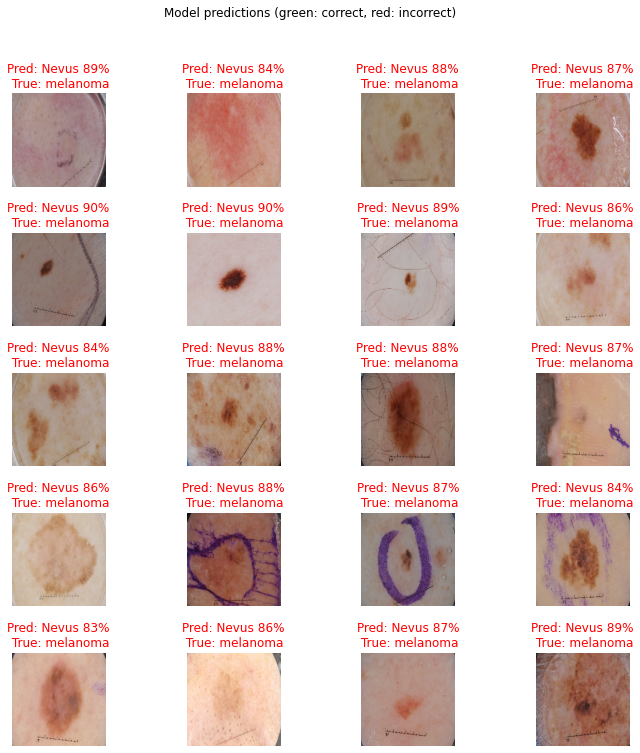

In [348]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(5,4,n+1)
  plt.imshow(image_batch[n])

  predict_for_n=predicted_batch[n]
  if predicted_labels[n] == true_labels[n]: 
    color = "green"
    plt.title("{} {:2.0f}%".format(predicted_label_names[n].title(), 100*np.max(predict_for_n)), color=color)
  else: 
    color= "red"
    plt.title("Pred: {} {:2.0f}%\n True: {}".format(predicted_label_names[n].title(), 100*np.max(predict_for_n), label_names[true_labels[n]]), 
              color=color)

  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Save Model and weights

In [349]:
# Save the Model Weights
model.save('CNN_model_skin_cancer.h5')

# Save the Model Weights
model.save_weights('model_weights_skin_cancer.h5')

# Save the Model to JSON
model_json = model.to_json()
with open('CNN_model_skin_cancer.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Model saved to the directory.')

Model saved to the directory.
